## In this notebook I want to see if training on a single sequence I am able to do a good PCA

In [1]:
## One analisys was done filtering N>=70 and M<=1000(gave 2ixTC00), the other N>=700, M<=10000(gave 3fbkA00)
## Third (the second could not sample from bmDCA somehow N>=100, M<=10000 gave (2cq4A01))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys


sys.path.insert(1, "./../util")
sys.path.insert(1, "./../model")
from encoded_protein_dataset_new import get_embedding, EncodedProteinDataset_new, EncodedProteinDataset_aux, collate_fn_new#, dynamic_collate_fn
from pseudolikelihood import get_npll2, get_npll_indep
import torch, torchvision
from torch.nn.utils import clip_grad_norm_
from potts_decoder import PottsDecoder
from torch.utils.data import DataLoader, RandomSampler
from functools import partial
import biotite.structure
from biotite.structure.io import pdbx, pdb
from biotite.structure.residues import get_residues
from biotite.structure import filter_backbone
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence
from typing import Sequence, Tuple, List
import scipy
from tqdm import tqdm
import pandas as pd
import csv
import time
from torch.utils.tensorboard import SummaryWriter

#import pytorch_warmup as warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR

##TURIN HPC
#sys.path.insert(1, "/Data/silva/esm/")

## EUROPA
#sys.path.insert(1, "/home/lucasilva/esm/")

##Lucas computer
sys.path.insert(1, "/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/")
import esm
#from esm.inverse_folding import util
import esm.pretrained as pretrained
from ioutils import read_fasta, read_encodings
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
from Bio import SeqIO



In [4]:
from dynamic_loader import dynamic_collate_fn, dynamic_cluster

In [6]:
### IDEA: MSAS PROCEDURE CAN GIVE DIFFERENT OUTPUT SHAPES? ASK
max_msas = 1
#msa_dir = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/msas/"
msa_dir = "/home/luchinoprince/split2/"
encoding_dir ="/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings"

train_dataset = EncodedProteinDataset_aux(os.path.join(msa_dir, 'train'), encoding_dir, noise=0.02, max_msas=max_msas)          ## Default value of noise used


In [7]:
batch_structure_size = 1   ### I think with empty GPU we can go up to 16 easily
perc_subset_test = 1.0     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 128 ### old is 32, original is 16
q = 21 ##isn't always 21
#dynamic_collate_fn

collate_fn = partial(dynamic_collate_fn, q=q, batch_size=batch_structure_size, batch_msa_size=batch_msa_size)
train_loader = DataLoader(train_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=True,
num_workers=1, pin_memory=True)




In [8]:
train_dataset[0][0].shape

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/Inverse_Folding/tests/./../util/encoded_protein_dataset_new.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


torch.Size([11439, 97])

In [9]:
decoder = None
embedding = None
torch.cuda.empty_cache()

seed = 24877
torch.random.manual_seed(seed)
np.random.seed(seed)



update_steps = 10000                                    ##Usual values are update steps=10^5, test_steps=10^2
bk_iter = False                                                  ## This tells us how ofter we save a model(default values is every ten-thousand updates)
#n_epochs = update_steps//(len(train_dataset)//batch_structure_size)   ## the other update steps will be used for "partial epochs", I want to save the last complet epoch
#print(f"With update_steps:{update_steps} we will do {n_epochs} full epochs")

input_encoding_dim = 512
param_embed_dim = 512
n_param_heads = 48
d_model = 512 ##old 512
n_heads = 8 ## old 8
n_layers = 6
## Check before running which is the GPU which is free the most and put it as the running device
device = 0        ## DON'T SET TO ONE OTHER THAN IN SPECIAL SPECIAL OCCASIONS, VERY NOISYYYYY!
dropout = 0.1

decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)
decoder.to(device)
embedding = get_embedding(q)
embedding.to(device)

Embedding(22, 21)

In [10]:
def get_loss_new(decoder, inputs, eta_J, eta_h):
    """eta_J is the multiplicative term in front of the penalized negative pseudo-log-likelihood for the Couplings
        if no penalty is proveded for the fields, we put the equal to one another """
    msas, encodings, padding_mask  = [input.to(device, non_blocking=True) for input in inputs]
    B, M, N = msas.shape
    #print(msas[0,1,1:5])
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    param_embeddings, fields = decoder.forward_new(encodings, padding_mask)
    msas_embedded = embedding(msas)
    #eta = eta_J
    # get npll
    npll = get_npll2(msas_embedded, param_embeddings, fields, N, q)
    padding_mask_inv = (~padding_mask)
    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    
    Q = torch.einsum('bkuia, buhia->bkhia', 
                param_embeddings.unsqueeze(2), param_embeddings.unsqueeze(1)).sum(axis=-1)
    #penalty = eta*(torch.sum(torch.sum(Q,axis=-1)**2) - torch.sum(Q**2) + torch.sum(fields**2))/B
    penalty = eta_J/B*(torch.sum(torch.sum(Q,axis=-1)**2) - torch.sum(Q**2)) + eta_h/B*torch.sum(fields**2) 
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 




def get_loss_loader(decoder, loader, eta_J, eta_h):
    decoder.eval()
    losses = []
    #with torch.no_grad():
    for effective_batch_size, inputs_packed in loader:
        npll_full = 0
        for inputs in inputs_packed:
            mini_batch_size = inputs[0].shape[0]
            #_, npll = get_loss_indep(decoder, inputs, eta_J, eta_h) ## For independent model without couplings
            _, npll = get_loss_new(decoder, inputs, eta_J, eta_h)
            npll_full += npll*mini_batch_size/effective_batch_size
        losses.append(npll_full)
            #del inputs
    
    return np.mean(losses)

def train(decoder, inputs_packed, eta_J, eta_h, optimizer, scaler):
    effective_batch_size = inputs_packed[0]
    loss_penalty_full = 0
    train_loss_full = 0
    optimizer.zero_grad(set_to_none=True)                           ## set previous gradients to 0
#    with torch.cuda.amp.autocast():  ## autocasting mixed precision
    for inputs in inputs_packed[1]:
        mini_batch_size = inputs[0].shape[0]
        #loss_penalty, train_batch_loss = get_loss_indep(decoder, inputs, eta_J, eta_h)    ## get the current loss for the batch this is for the independent training
        loss_penalty, train_batch_loss = get_loss_new(decoder, inputs, eta_J, eta_h)
        loss_penalty = loss_penalty * mini_batch_size/effective_batch_size
        train_batch_loss = train_batch_loss * mini_batch_size/effective_batch_size
        #loss_penalty.backward()                         ## Get gradients
        #scaler.scale(loss_penalty).backward()
        loss_penalty.backward()
        loss_penalty_full += loss_penalty.detach()
        train_loss_full += train_batch_loss
    
    
    #scaler.step(optimizer)
    #scaler.update()
    optimizer.step()   

    return loss_penalty_full, train_loss_full

In [11]:
## Let us also save the hyperparameters
#with summary_writer as w:
import warnings
warnings.filterwarnings("ignore")
lr = 1e-4
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr)
eta_J = 1e-4
eta_h = 1e-4

start = time.time()
scaler = torch.cuda.amp.GradScaler()
with tqdm(total = update_steps) as pbar: ##This is used to have the nice loading bar while training
    train_loss = 0
    update_step = 0
    max_gpu=0
    train_batch_losses = []
    train_batch_losses_penalty = []
    epoch = 0.0
    while update_step < update_steps:
        for inputs_packed in train_loader:
            decoder.train()

            loss_penalty, train_batch_loss = train(decoder, inputs_packed, eta_J, eta_h, optimizer, scaler)
            loss_penalty.detach()
            #optimizer.step()                                ## Do a step of GD
            update_step += 1                                ## Increase update step (the update steps will count also different batches within the same epoch)
            epoch = update_step / len(train_loader)
            
            train_batch_losses.append(train_batch_loss) ## Here we append the lossess in the different batches within the same epoch
            train_batch_losses_penalty.append(loss_penalty.item())

        
            pbar.set_description(f'update_step: {update_step}, epoch: {epoch:.2f}  train: {train_loss:.2f}')
            pbar.update(1)
            
print(f"It took {time.time()-start} seconds")


update_step: 589, epoch: 589.00  train: 0.00:   6%|▌         | 589/10000 [00:33<08:44, 17.96it/s]Exception ignored in: <function _releaseLock at 0x7fe031f865e0>
Traceback (most recent call last):
  File "/home/luchinoprince/anaconda3/envs/IF/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
update_step: 804, epoch: 804.00  train: 0.00:   8%|▊         | 803/10000 [00:45<08:34, 17.87it/s]

update_step: 811, epoch: 811.00  train: 0.00:   8%|▊         | 811/10000 [00:45<08:55, 17.16it/s]

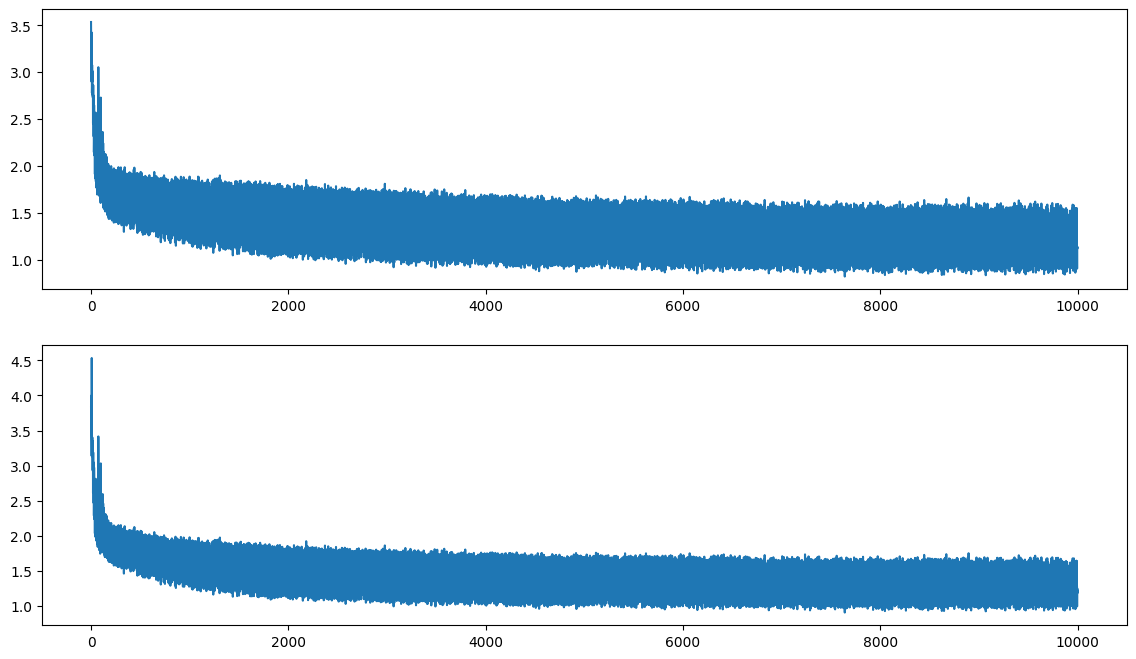

In [11]:
fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
ax1.plot(train_batch_losses[1:10000])
ax2.plot(train_batch_losses_penalty[1:10000])

In [12]:
train_dataset.msas_paths

['/home/luchinoprince/split2/train/2cq4A01_train.a3m.pt',
 '/home/luchinoprince/split2/train/2jm4A00_train.a3m.pt',
 '/home/luchinoprince/split2/train/3pv4A01_train.a3m.pt',
 '/home/luchinoprince/split2/train/4i92A01_train.a3m.pt',
 '/home/luchinoprince/split2/train/2k1mA00_train.a3m.pt',
 '/home/luchinoprince/split2/train/2id3A01_train.a3m.pt',
 '/home/luchinoprince/split2/train/1k8mA00_train.a3m.pt',
 '/home/luchinoprince/split2/train/2fx0A01_train.a3m.pt',
 '/home/luchinoprince/split2/train/1p1dA02_train.a3m.pt',
 '/home/luchinoprince/split2/train/4mo7A01_train.a3m.pt']

In [13]:
train_msa=torch.load(train_dataset.msas_paths[0]).to(torch.int)

In [14]:
train_msa.shape

torch.Size([11439, 97])

In [15]:
decoder.eval()

for inputs_packed in train_loader:
    for inputs in inputs_packed[1]:
        msas, encodings, padding_mask  = [input.to(device, non_blocking=True) for input in inputs]
        B, M, N = msas.shape
        #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
        couplings, fields = decoder(encodings, padding_mask)
        if N == 97:
            break;
    if N == 97:
        break


In [16]:
N

97

In [17]:
### If all False + n=97 tell us that the protein we wanted is in the current batch, otherwise rerun above code until it happens.
print(N)
padding_mask[0, ::]


97


tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False], device='cuda:0')

In [18]:
couplings.shape

torch.Size([1, 2037, 2037])

In [23]:
## Remember that when we have a batch we hav that we order 
## the MSA within the batch in decreasing order of lenght
#fields[1, :]

In [19]:
fields[0,:]

tensor([-0.0260, -0.0373, -0.0415,  ..., -0.0768, -0.0042,  0.0152],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [20]:
msas[0,:,:]

tensor([[20, 20, 20,  ..., 20, 20, 20],
        [20, 15, 12,  ...,  5,  3,  5],
        [20, 15, 12,  ..., 14, 12,  5],
        ...,
        [20, 15,  5,  ..., 20, 20, 20],
        [20, 20, 20,  ..., 20, 20, 20],
        [20, 15,  5,  ..., 20, 20, 20]], device='cuda:0', dtype=torch.int32)

In [21]:
B

1

In [22]:
if B>1:
    couplings = couplings[0:1,:,:]
    fields=fields[0:1,:]

In [23]:
couplings.shape

torch.Size([1, 2037, 2037])

In [24]:
N

97

In [25]:
## In this folder I will save the model in consideration, I won't save all of them due to memory
#auxiliary_model_dir = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Auxiliary_Potts'
auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
#auxiliary_model_dir = "."

#B,N,_ = rep_padded.shape
with open(os.path.join(auxiliary_model_dir, "4x28c01_couplings_fields.txt"), "w") as f:
    ## write J
    for i in range(N):
        for j in range(i+1, N):
            for aa1 in range(q):
                for aa2 in range(q):
                    J_el = couplings[0, i*q+aa1, j*q+aa2].detach().to('cpu').item()
                    line = "J " + str(i) + " " + str(j) + " "+ str(aa1) + " " + str(aa2) + " " + str(J_el) +"\n"
                    f.write(line)
    
    ## write h
    for i in range(N):
        for aa in range(q):
            h_el = fields[0, i*q+aa1].detach().to('cpu').item()
            line = "h " + str(i) + " " + str(aa) + " " + str(h_el) + "\n"
            f.write(line)

In [26]:
auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
out_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'
out_file = 'samples.txt'
samples_path = os.path.join(auxiliary_model_dir, "4x28c01_couplings_fields.txt")
## The ! creates a terminal command, to pass variable you need to put square brackets
!(bmdca_sample -p {samples_path} -n 1000 -d {out_dir} -o {out_file})

initializing sampler... 0.0185433 sec

sampling model with mcmc... 0.460423 sec
updating mcmc stats with samples... 0.0156208 sec
computing sequence energies and correlations... 0.03391 sec
writing final sequences... done


In [27]:
def compute_covariance(msa, q):
    """
    Compute covariance matrix of a given MSA having q different amino acids
    """
    M, N = msa.shape

    # One hot encode classes and reshape to create data matrix
    D = torch.flatten(one_hot(msa, num_classes=q), start_dim=1).to(torch.float32)

    # Remove one amino acid
    D = D.view(M, N, q)[:, :, :q-1].flatten(1)

    # Compute bivariate frequencies
    bivariate_freqs = D.T @ D / M
    
    # Compute product of univariate frequencies
    univariate_freqs = torch.diagonal(bivariate_freqs).view(N*(q-1), 1) @ torch.diagonal(bivariate_freqs).view(1, N*(q-1))

    return bivariate_freqs - univariate_freqs

In [28]:
alphabet='ACDEFGHIKLMNPQRSTVWY-'
default_index = alphabet.index('-')
aa_index = defaultdict(lambda: default_index, {alphabet[i]: i for i in range(len(alphabet))})
aa_index_inv = dict(map(reversed, aa_index.items()))

In [29]:
import torch.nn.functional as F
from torch.nn.functional import one_hot

In [30]:
################# NOT SURE THIS MAKES SENSE, I THINK WE CAN JUST THE THE NUMERICAL VALUES, NO NEED FOR TRANSLATION
##### THE bmDCA code works by generating according to potts, and the translating, hence we just have to 
##### avoid looking at the translated one.
file='samples_numerical.txt'
with open(os.path.join(out_dir,file), mode='r') as f:
    lines=f.readlines()

char_seq = [] ##36 is the lenght of YAP

for i in range(1, len(lines)):
    line = lines[i][0:-1].split(" ") ## I take out the end of file
    line_char = [aa_index_inv[int(idx)] for idx in line]
    char_seq.append(line_char)
    
## Now re-translate
for prot_idx in range(len(char_seq)):
    for aa in range(len(char_seq[prot_idx])):
        char_seq[prot_idx][aa] = aa_index[char_seq[prot_idx][aa]]
        
msa_t = torch.tensor(char_seq, dtype=torch.long)
cov_potts = compute_covariance(msa_t, 21)

In [31]:
msa_t[0:5, 0:18]

tensor([[20, 20, 20, 20, 20, 20, 20, 20, 20, 20,  9,  4,  7,  5,  5,  9, 15, 18],
        [20, 20, 20, 20, 20, 20,  2, 20, 20, 20,  9,  4,  7,  5,  5,  9, 15, 19],
        [20, 20, 20, 20, 20, 20, 20, 20, 14, 20,  9,  4,  7,  5,  5,  7, 15, 18],
        [20, 20, 20, 20, 20, 20, 20, 20, 20, 20,  9,  4,  7,  5,  5,  7, 15, 19],
        [20, 20, 20, 20, 20, 20, 20,  3, 20, 20,  9,  4,  7,  5,  5,  7, 16, 19]])

In [32]:
msa_t.type()

'torch.LongTensor'

In [35]:
def get_embedding(q):

    embedding = torch.nn.Embedding(q+1, q).requires_grad_(False)
    embedding.weight.data.zero_()

    embedding.weight[:q, :q] = torch.eye(q)

    return embedding
embeddings = get_embedding(q)

In [56]:
M_potts, N = msa_t.shape
msa_t_emb = embeddings(msa_t).reshape(M_potts, N*q)
M_train, N = train_msa.shape
train_msa_emb = (embeddings(train_msa)).reshape(M_train, N*q)

In [57]:
msa_t_emb.shape

torch.Size([10000, 2037])

In [52]:
from sklearn.decomposition import PCA
pca_mse = PCA(n_components=2)
pca_mse = pca_mse.fit(train_msa_emb)

In [42]:
#a,b,c = np.linalg.svd(train_msa)

In [53]:
train_msa.shape

torch.Size([11439, 97])

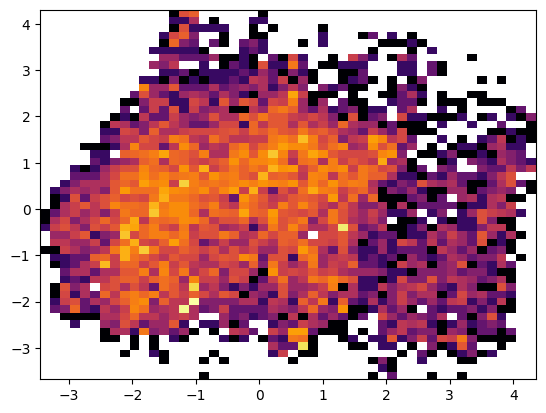

In [54]:
proj_true = pca_mse.transform(train_msa_emb)
# Generate some test data
x = proj_true[:,0]
y = proj_true[:, 1]
from matplotlib import colors

fig, ax = plt.subplots(nrows=1, ncols=1)

#heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#plt.clf()
#plt.imshow(heatmap.T, extent=extent, origin='lower', cmap="inferno")

ax.hist2d(x, y, bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()

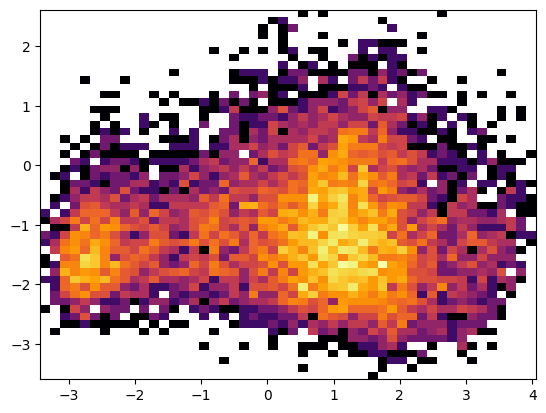

In [58]:
proj_potts = pca_mse.transform(msa_t_emb)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist2d(proj_potts[:, 0], proj_potts[:, 1], bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()


In [90]:
msa_full=train_dataset[0][0]
msa_full.shape

torch.Size([11439, 97])

In [91]:
import h5py

In [92]:
with h5py.File('tensor_data_2cq4A01.h5', 'w') as file:
    # Create a dataset in the file
    dataset = file.create_dataset('tensor', data=msa_full)

### LOOK at _aux_julia.ipynb_

In [120]:
couplings2 = np.load("couplings_MSA.npy")
fields2 = np.load("fields_MSA.npy")

In [121]:
fields2

array([[-0.02339776,  0.0228768 ,  0.00869066, ...,  0.03118484,
         0.00118039, -0.0140192 ],
       [-0.02339776, -0.02756039, -0.03640457, ..., -0.04393613,
        -0.03206675, -0.0140192 ],
       [-0.02339776, -0.01231941,  0.00619111, ...,  0.02180152,
        -0.00713179, -0.0140192 ],
       ...,
       [-0.02339776, -0.03297511, -0.04353639, ..., -0.03048971,
        -0.03888294, -0.0140192 ],
       [-0.02339776, -0.03100165, -0.02864255, ..., -0.01630292,
        -0.02360864, -0.0140192 ],
       [ 0.1192325 ,  0.03538395,  0.00217436, ...,  0.02550837,
         0.07193026,  0.11076408]])

In [122]:
q,N=fields2.shape
M_potts, N = msa_t.shape


In [123]:
couplings2.shape

(21, 21, 97, 97)

In [124]:
## In this folder I will save the model in consideration, I won't save all of them due to memory
auxiliary_model_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'
#auxiliary_model_dir = "."

#B,N,_ = rep_padded.shape
with open(os.path.join(auxiliary_model_dir, "benchmark.txt"), "w") as f:
    ## write J
    for i in range(N):
        for j in range(i+1, N):
            for aa1 in range(q):
                for aa2 in range(q):
                    J_el = couplings2[aa1, aa2, i, j]
                    line = "J " + str(i) + " " + str(j) + " "+ str(aa1) + " " + str(aa2) + " " + str(J_el) +"\n"
                    f.write(line)
    
    ## write h
    for i in range(N):
        for aa in range(q):
            h_el = fields2[aa, i]
            line = "h " + str(i) + " " + str(aa) + " " + str(h_el) + "\n"
            f.write(line)

In [125]:
auxiliary_model_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'
out_dir = auxiliary_model_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'

out_file = 'samples_benchmark.txt'
samples_path = os.path.join(auxiliary_model_dir, "benchmark.txt")
## The ! creates a terminal command, to pass variable you need to put square brackets
!(bmdca_sample -n 1000 -p {samples_path} -d {out_dir} -o {out_file})

initializing sampler... 0.0192437 sec

sampling model with mcmc... 0.451982 sec
updating mcmc stats with samples... 0.0162195 sec
computing sequence energies and correlations... 0.0272794 sec
writing final sequences... done


In [126]:
file='samples_benchmark_numerical.txt'
with open(os.path.join(out_dir,file), mode='r') as f:
    lines=f.readlines()

char_seq = [] ##36 is the lenght of YAP

for i in range(1, len(lines)):
    line = lines[i][0:-1].split(" ") ## I take out the end of file
    line_char = [aa_index_inv[int(idx)] for idx in line]
    char_seq.append(line_char)
    
## Now re-translate
for prot_idx in range(len(char_seq)):
    for aa in range(len(char_seq[prot_idx])):
        char_seq[prot_idx][aa] = aa_index[char_seq[prot_idx][aa]]
        
msa_t2 = torch.tensor(char_seq, dtype=torch.long)
cov_bk = compute_covariance(msa_t2, 21)

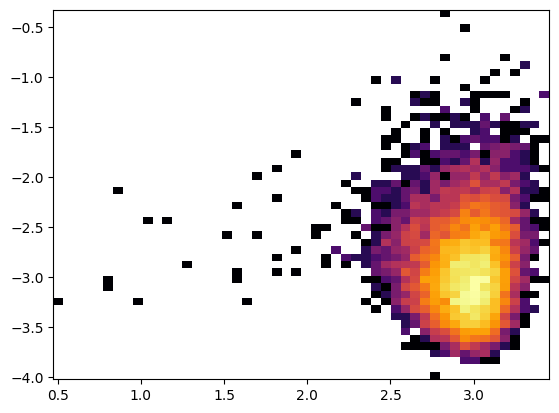

In [127]:
M_bk, N = msa_t2.shape
msa_t2_emb = embeddings(msa_t2).reshape(M_bk, N*q)
proj_potts2 = pca_mse.transform(msa_t2_emb)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist2d(proj_potts2[:, 0], proj_potts2[:, 1], bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()

#### THIS SEEMS VERY VERY ODD, LET US SEE THE SINGLE SITE FREQUENCIES OF THE THREE MSA

In [128]:
train_msa = train_msa.to(torch.int)

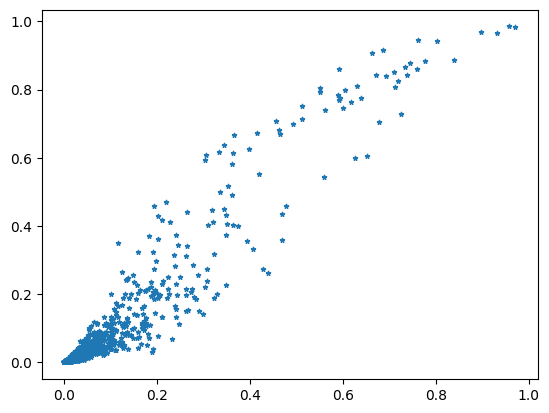

In [129]:
M,N = train_msa.shape 
M_potts = msa_t.shape[0]
fi_potts = torch.sum(embeddings(msa_t), dim=0)/M_potts
msa_true_emb = embeddings(train_msa)
fi_true=torch.sum(msa_true_emb, dim=0)/M
plt.scatter(fi_true.flatten(), fi_potts.flatten(), marker="*", s=10)

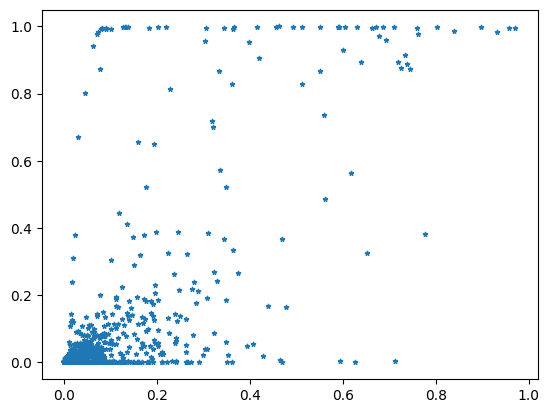

In [130]:
M,N = train_msa.shape 
M_potts2 = msa_t2.shape[0]
fi_potts2 = torch.sum(embeddings(msa_t2), dim=0)/M_potts2
msa_true_emb = embeddings(train_msa)
fi_true=torch.sum(msa_true_emb, dim=0)/M
plt.scatter(fi_true.flatten(), fi_potts2.flatten(), marker="*", s=10)

#### Second order

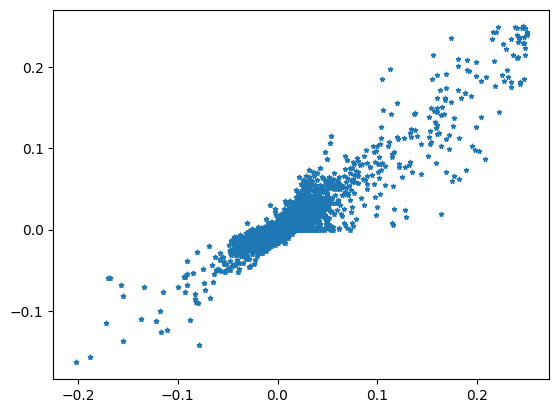

In [70]:
plt.scatter(cov_potts.flatten(), cov_bk.flatten(), marker="*", s=10)

In [61]:
cov_true = compute_covariance(train_msa.long(), q)

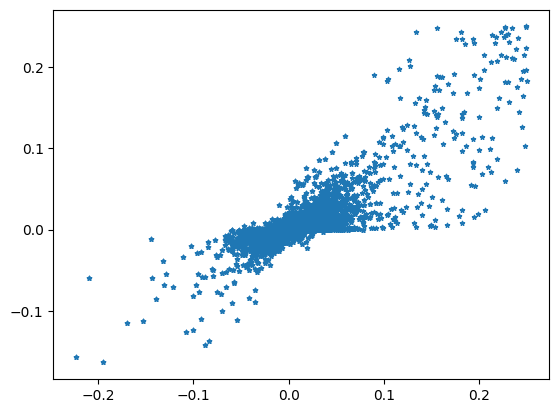

In [237]:
plt.scatter(cov_true.flatten(), cov_bk.flatten(), marker="*", s=10)

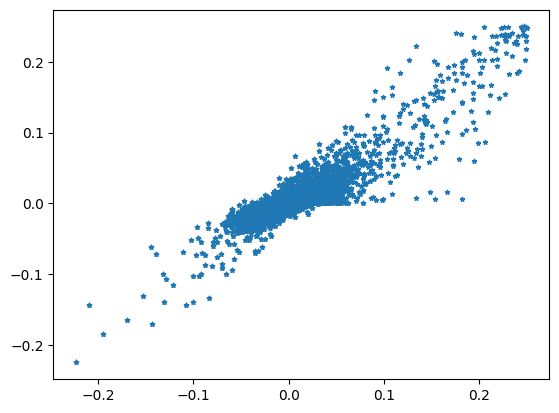

In [238]:
plt.scatter(cov_true.flatten(), cov_potts.flatten(), marker="*", s=10)

In [63]:
scipy.stats.pearsonr(cov_true.flatten(), cov_potts.flatten())

PearsonRResult(statistic=0.7679884219957847, pvalue=0.0)

In [62]:
scipy.stats.pearsonr(cov_true.flatten(), cov_bk.flatten())

PearsonRResult(statistic=0.6911845054747521, pvalue=0.0)

## Checking the family they use in ArDCA to see if there could be a problem in how I do the PCA

#### Solved but forgot to save, recreate

In [3]:
from ioutils import read_fasta

In [4]:
fasta = "/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/ArDCAData/data/PF00076/PF00076_mgap6.fasta"
msa = read_fasta(fasta)

In [7]:
msa[0].shape

torch.Size([137605, 70])

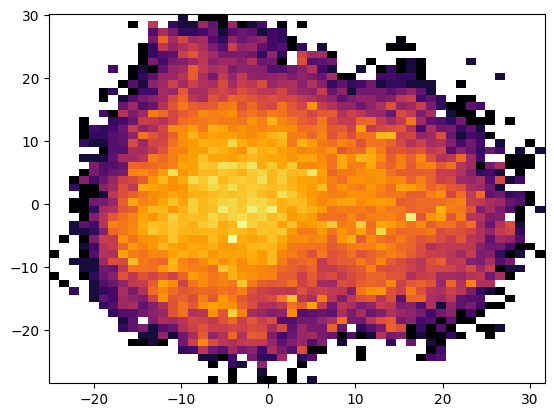

In [11]:
from sklearn.decomposition import PCA
pca_mse = PCA(n_components=2)
proj_true = pca_mse.fit_transform(msa[0])
# Generate some test data
x = proj_true[:,0]
y = proj_true[:, 1]
from matplotlib import colors

fig, ax = plt.subplots(nrows=1, ncols=1)

ax.hist2d(x, y, bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()

## Let us test if the training with arDCA helps in some of the plots

In [136]:
samples_ardca=np.transpose(np.load("samples_ardca.npy"))
samples_ardca.shape

(10000, 97)

In [137]:
M_ardca, N = samples_ardca.shape
msa_ardca_emb = (embeddings(torch.tensor(samples_ardca))).reshape(M_ardca, N*q)

In [138]:
msa_ardca_emb.shape

torch.Size([10000, 2037])

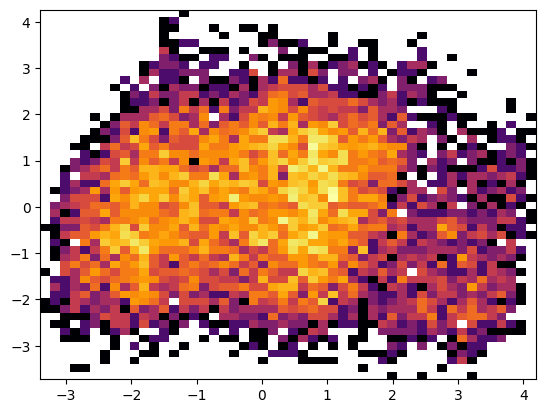

In [139]:
proj_ardca = pca_mse.transform(msa_ardca_emb)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist2d(proj_ardca[:, 0], proj_ardca[:, 1], bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()


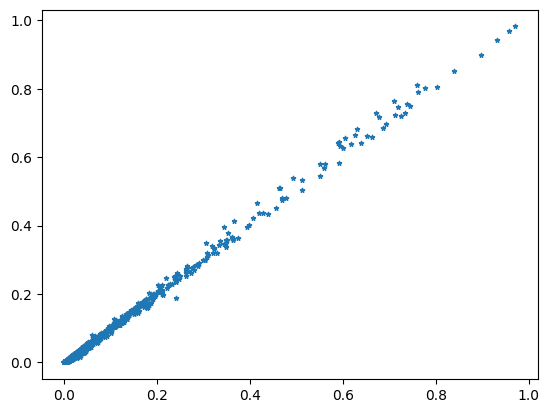

In [140]:
fi_ardca = torch.sum(msa_ardca_emb, dim=0)/M_ardca
plt.scatter(fi_true.flatten(), fi_ardca.flatten(), marker="*", s=10)